# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import scipy as sp
import scipy.stats as stats
import sklearn

In [3]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - n \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum{i=1}^N y_i = 0 \\
& n \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{n} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{n} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{n} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x} - \hat{\beta}_1 x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [4]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [5]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [6]:
boston.data.shape

(506, 13)

In [7]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [8]:
# Print description of Boston housing data set
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [9]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [10]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [11]:
print(boston.target.shape)

(506,)


In [12]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [13]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

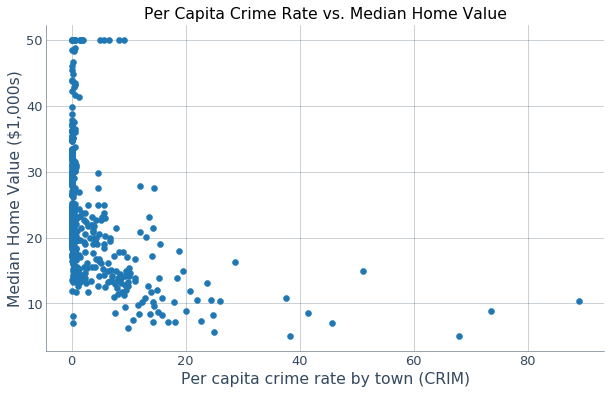

In [14]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Median Home Value ($1,000s)")
plt.title("Per Capita Crime Rate vs. Median Home Value");

***
<div class="alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>

<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

In [15]:
# Calculate Peason's R for each feature:

correlation = bos.corr()
correlation.iloc[[-1]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
PRICE,-0.385832,0.360445,-0.483725,0.17526,-0.427321,0.69536,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663,1.0


<div class="alert alert-success">
<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>
<ol>
    <li>Housing prices are capped at a median value of \$50,000. </li>   
    <li>This data is very old!  Capping median home values at \$50,000 is at least two orders of magnitude lower than what would be appropriate today.</li>
    <li>There is a negative correlation between home prices and crime per capita for median home values between \$15,000 and about \$30,000.  Above \$30,000, crime holds steadily low.  Below about \$15,000, crime rates are largely independent of house prices.</li>
    <li>There are some extreme outliers beyond a per capita crime rate of about 25, but they do not appear to be correlated to the median home value.</li>
</ol>

</div>

***
<div class="alert alert-info">
<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>
</div>

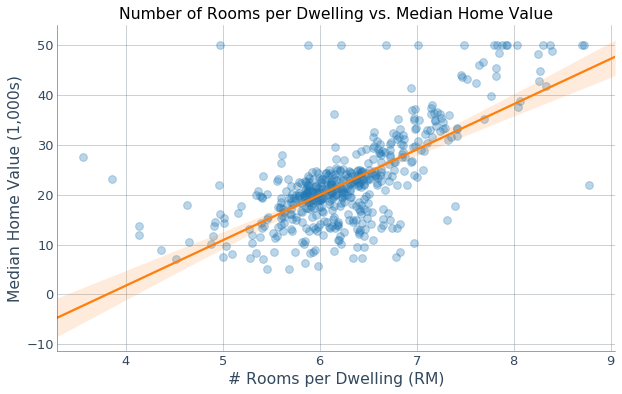

In [16]:
# reg plot: # Rooms v Median Home Value
sns.regplot(x='RM', y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('# Rooms per Dwelling (RM)')
_ = plt.ylabel('Median Home Value (1,000s)')
_ = plt.title('Number of Rooms per Dwelling vs. Median Home Value');

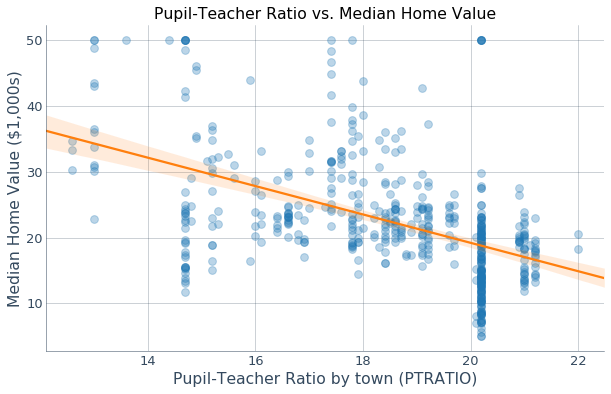

In [17]:
# reg plot: Pupil-Teacher Ratio vs. Median Home Value
sns.regplot(x='PTRATIO', y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('Pupil-Teacher Ratio by town (PTRATIO)')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('Pupil-Teacher Ratio vs. Median Home Value');

<div class="alert alert-success">
<ol>
    <li>While there are outliers in each direction, there is a strong, positive correlation between the average number of rooms per dwelling and the median home price.</li>
    <li>There is a negative correlation between the pupil-teacher ratio and median home value; as the ratio grows larger, the median home values decrease.</li>
</ol>
</div>

***
<div class="alert alert-info">
<p><p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p> </p>
</div>

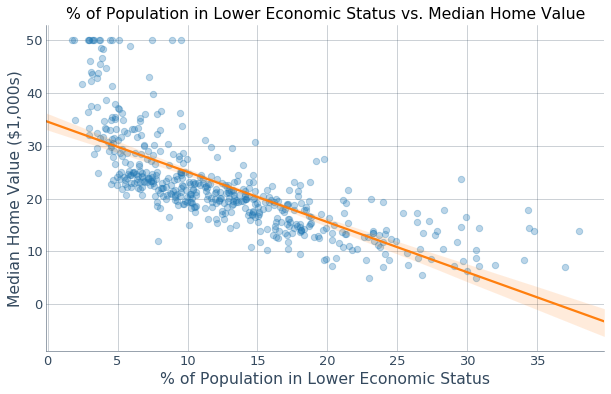

In [18]:
# reg plot: Economic Status vs. Median Home Value
sns.regplot(x='LSTAT', y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':40}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('% of Population in Lower Economic Status')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('% of Population in Lower Economic Status vs. Median Home Value');

<div class="alert alert-success">
Unsurprisingly, there is a negative correlation between economic status and median housing price.  Median home values are lower in areas where larger percentages of the population are members of the lower economic classes.
</div>

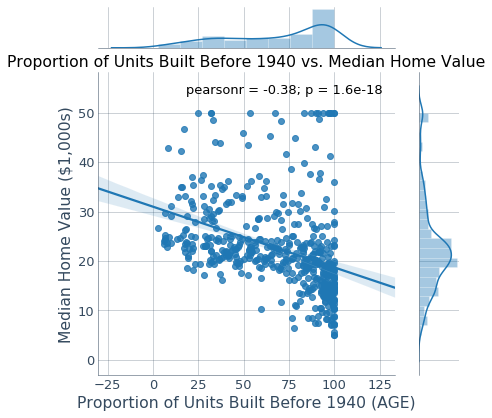

In [19]:
# jointplot: 
sns.jointplot('AGE', 'PRICE', data = bos, kind = 'reg', space=0.6)

_ = plt.xlabel('Proportion of Units Built Before 1940 (AGE)')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('Proportion of Units Built Before 1940 vs. Median Home Value');

<div class="alert alert-success">
There is a slight negative correlation between the median home values and the age of a town, where towns with larger percentages of older units have slightly lower median values.
</div>

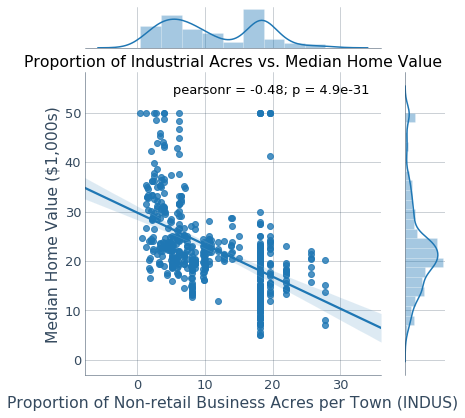

In [20]:
# jointplot: 
sns.jointplot('INDUS', 'PRICE', data = bos, kind = 'reg', space=0.6)

_ = plt.xlabel('Proportion of Non-retail Business Acres per Town (INDUS)')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('Proportion of Industrial Acres vs. Median Home Value');

<div class="alert alert-success">
There is a negative correlation between the median home values and the proportion of non-retail business space, where areas with larger percentages of non-retail business space have lower median values.
</div>

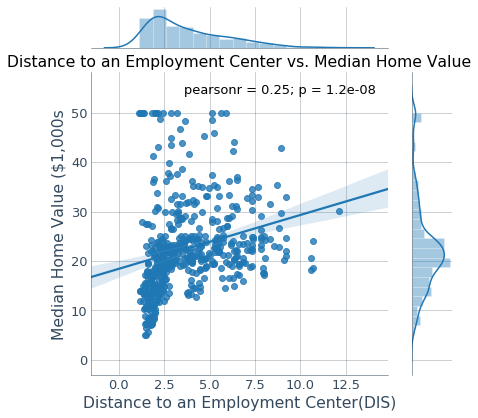

In [21]:
# jointplot: 
sns.jointplot('DIS', 'PRICE', data = bos, kind = 'reg', space=0.6)

_ = plt.xlabel('Distance to an Employment Center(DIS)')
_ = plt.ylabel('Median Home Value ($1,000s')
_ = plt.title('Distance to an Employment Center vs. Median Home Value');

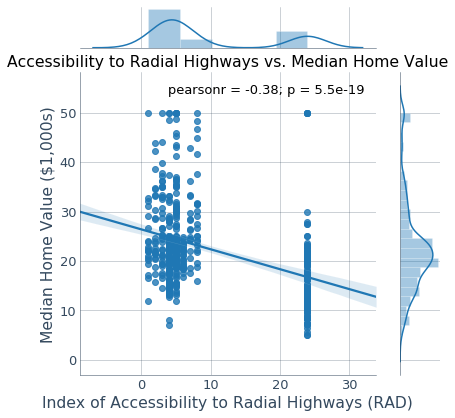

In [22]:
# jointplot: 
sns.jointplot('RAD', 'PRICE', data = bos, kind = 'reg', space=0.6)

_ = plt.xlabel('Index of Accessibility to Radial Highways (RAD)')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('Accessibility to Radial Highways vs. Median Home Value');

<div class="alert alert-success">
<p>There is a premium placed on homes closer to an employment center and/or with easier access to a radial highway.</p>
</div>

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

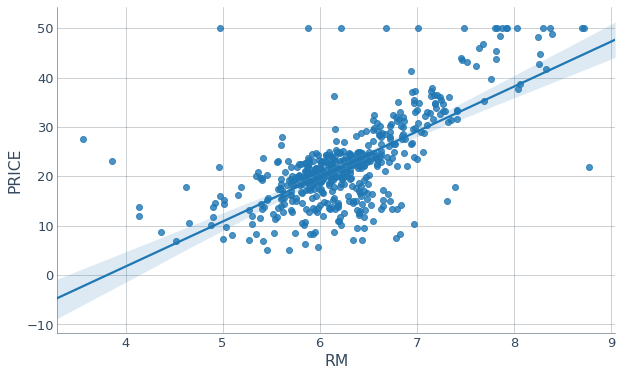

In [23]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True);

### Histograms
***


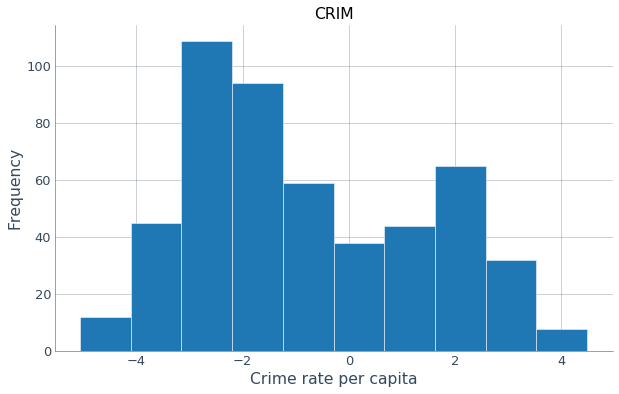

In [24]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")
plt.show();

***
<div class="alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?
</div>

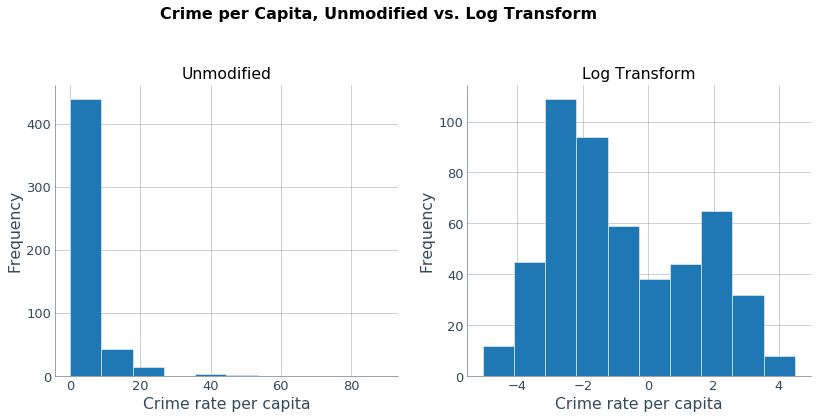

In [25]:
plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
plt.hist(bos.CRIM)
plt.title("Unmodified")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(np.log(bos.CRIM))
plt.title("Log Transform")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")

plt.suptitle('Crime per Capita, Unmodified vs. Log Transform', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show();

<div class="alert alert-success">
<p>Taking the log of the crime rate redistributes the data to give us a different perspective.  The transformed data spreads the data that was bunched at the low end of the unmodified histogram and reveals that the crime rate per capita is bimodal. </p>
</div>


<div class="alert alert-info">
<p><b>Exercise:</b> Plot histograms for *RM* and *PTRATIO*, along with the two variables you picked in the previous section.</p>
</div>

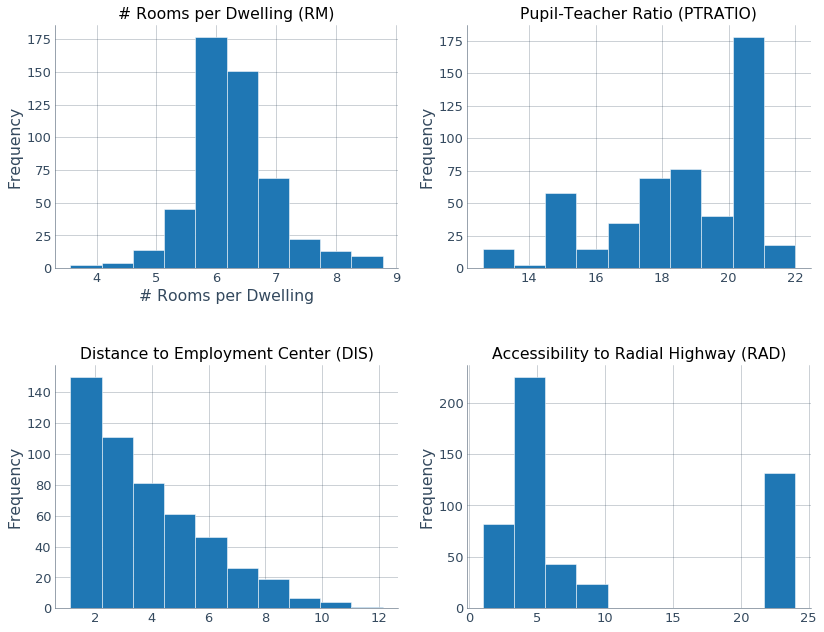

In [26]:
plt.subplots(2,2, figsize=(15,12))

plt.subplot(221)
plt.hist(bos.RM)
plt.title('# Rooms per Dwelling (RM)')
plt.xlabel('# Rooms per Dwelling')
plt.ylabel('Frequency')

plt.subplot(222)
plt.hist(bos.PTRATIO)
plt.title('Pupil-Teacher Ratio (PTRATIO)')
plt.ylabel('Frequency')

plt.subplot(223)
plt.hist(bos.DIS)
plt.title('Distance to Employment Center (DIS)')
plt.ylabel('Frequency')

plt.subplot(224)
plt.hist(bos.RAD)
plt.title('Accessibility to Radial Highway (RAD)')
plt.ylabel('Frequency')

plt.subplots_adjust(left=0.2, wspace=0.2, hspace=0.4, top=0.8)
plt.show();

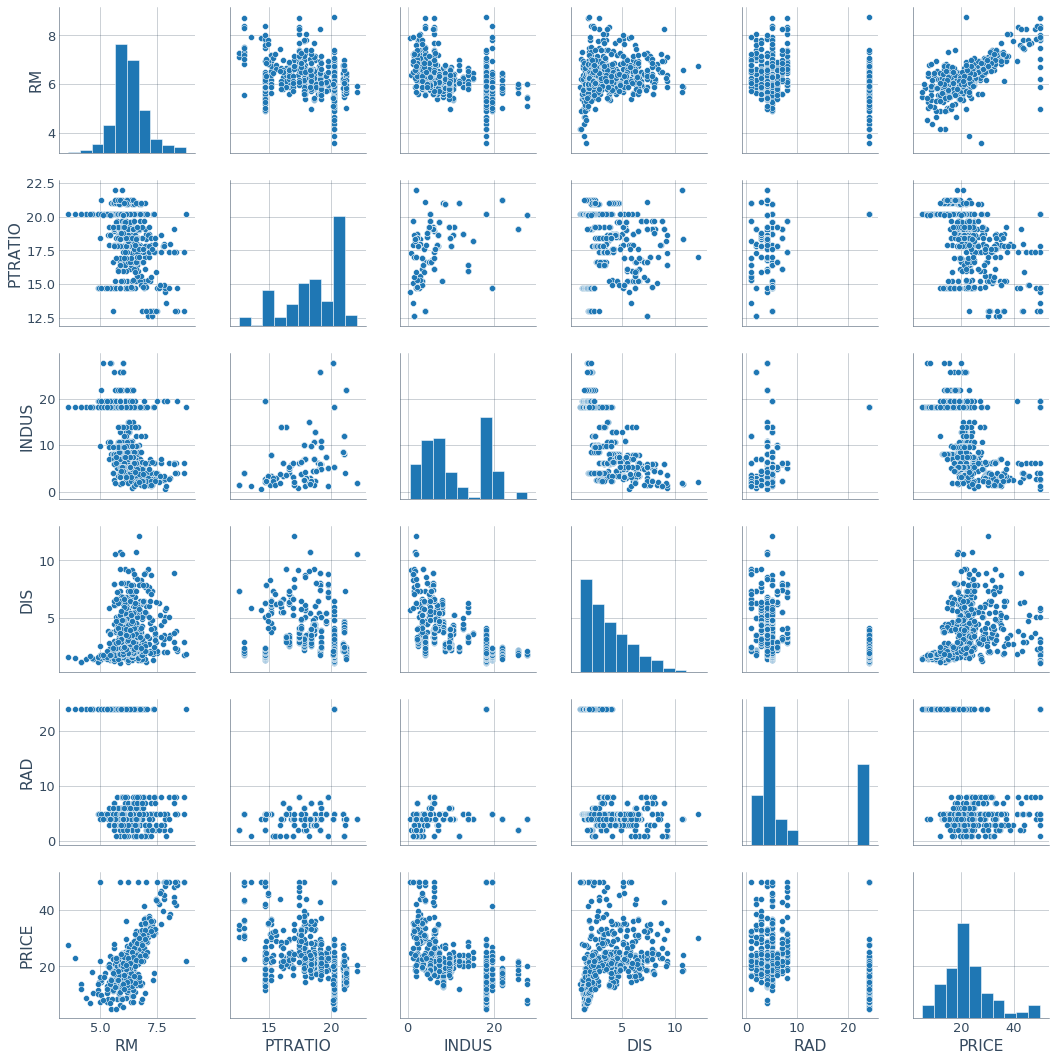

In [27]:
sns.pairplot(bos, vars=['RM', 'PTRATIO', 'INDUS', 'DIS', 'RAD', 'PRICE'])
plt.show();



## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [28]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [29]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 06 Jun 2018   Prob (F-statistic):           2.49e-74
Time:                        14:42:24   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is done like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call NumPy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

***
<div class="alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

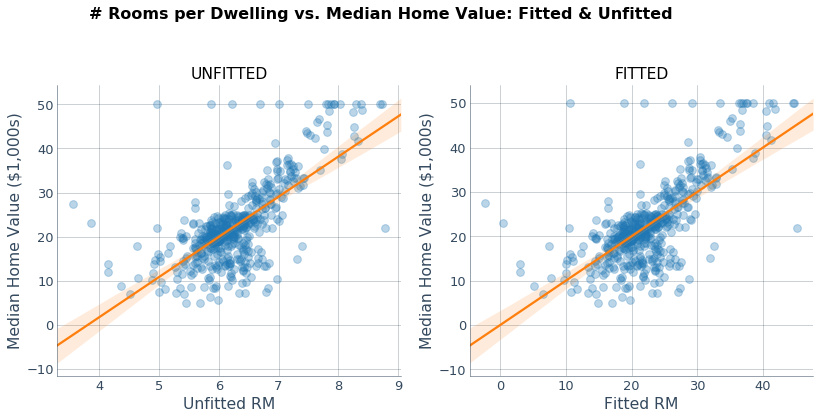

In [30]:
plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
sns.regplot(x='RM', y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('Unfitted RM')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('UNFITTED')

plt.subplot(122)
sns.regplot(x=m.fittedvalues, y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('Fitted RM')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('FITTED')

plt.suptitle('# Rooms per Dwelling vs. Median Home Value: Fitted & Unfitted', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show();

<div class="alert alert-success">
<p>The scale of the x axis has changed and no longer makes sense.  In the plot of fitted values, the number of rooms ranges between -3 and 55, but the plotted points all appear to be in the same places, relative to one another.</p>
</div>

### Fitting Linear Regression using `sklearn`


In [31]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [32]:
# Look inside lm object
# lm.<tab>


Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 


### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [33]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)
lm.coef_
lm.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([-1.07170557e-01,  4.63952195e-02,  2.08602395e-02,  2.68856140e+00,
       -1.77957587e+01,  3.80475246e+00,  7.51061703e-04, -1.47575880e+00,
        3.05655038e-01, -1.23293463e-02, -9.53463555e-01,  9.39251272e-03,
       -5.25466633e-01])

36.49110328036135

***
<div class="alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://online.stat.psu.edu/~ajw13/stat501/SpecialTopics/Reg_thru_origin.pdf).</p>
</div>

<div class="alert alert-success">
<p>If the `fit_intercept` parameter is set to `False` upon initialization of a `LinearRegression` instance, no intercept will be used in calculations.</p>
</div>

<div class="alert alert-info">
<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>
</div>

<div class="alert alert-success">
In order to use OLS regression, the residuals must:
<ol>
    <li>be independent </li>
    <li>have constant variance </li>
    <li>be normally distributed </li>
</ol>
IID refers to the first two criteria.  Normally distributed residuals need not necessarily be independent or have constant variance.
</div>

<div class="alert alert-info">
<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>

<div class="alert alert-success">
<p>False.  $Y$ does not need to be normally distributed to use linear regression.  In order to make inferences about the regression parameters, it is adequate to know that the regression coefficient estimates are consistent and asymptotically normal. Confidence intervals for parameter estimates can be obtained using normality, even if the response is not normally distributed, as long as the sample size is in the asymptotic region ("large enough").  

There are four principal assumptions which justify the use of linear regression models for purposes of inference or prediction:
<ol>
    <li>linearity and additivity of the relationship between dependent and independent variables: </li>
        <ol>
            <li>The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed. </li>
            <li>The slope of that line does not depend on the values of the other variables. </li>
            <li>The effects of different independent variables on the expected value of the dependent variable are additive. </li>
        </ol>
    <li>statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data) </li>
    <li>homoscedasticity (constant variance) of the errors </li>
        <ol>
            <li>versus time (in the case of time series data) </li>
            <li>versus the predictions </li>
            <li>versus any independent variable </li>
        </ol>
    <li>normality of the error distribution. </li>
    
</ol>

</div>

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [34]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.49110328036135


In [35]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [36]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [37]:
# first five predicted prices
lm.predict(X)[0:5]

array([30.00821269, 25.0298606 , 30.5702317 , 28.60814055, 27.94288232])

***
<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

</div>

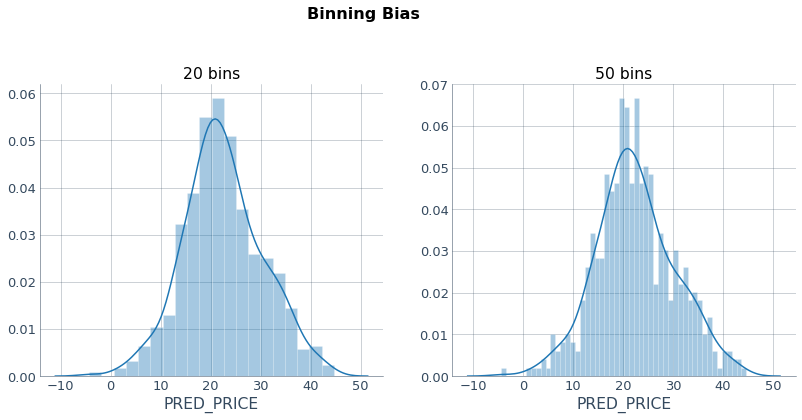

In [38]:
bos['PRED_PRICE'] = lm.predict(X)

plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
sns.distplot(bos['PRED_PRICE'], bins=20)
_ = plt.title('20 bins')

plt.subplot(122)
sns.distplot(bos['PRED_PRICE'], bins=50)
_ = plt.title('50 bins')

plt.suptitle('Binning Bias', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show();

In [39]:
preds = bos.PRED_PRICE

preds.describe()

count    506.000000
mean      22.532806
std        7.914896
min       -4.283009
25%       17.447270
50%       22.120625
75%       27.412587
max       44.673399
Name: PRED_PRICE, dtype: float64

<div class="alert alert-info">
<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>
</div>

<div class="alert alert-success">
<p>Both versions of the histogram for predicted prices are asymptotic, with a mean of \$22,532 and a median of \$22,120; slightly right-skewed.  The hist with 50 bins makes the negative outliers more apparent, and the `.describe()` verifies that the minimum predicted price is -\$4,283.  Predicted prices that are negative do not make sense.  We should look more closely to see if we can resolve or eliminate these predictions.</p>
</div>

<div class="alert alert-info">
<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see whether they disagree (we did this with `statsmodels` before).</p>
</div>

In [40]:
m = ols('PRICE ~ PRED_PRICE',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1439.
Date:                Wed, 06 Jun 2018   Prob (F-statistic):          8.56e-150
Time:                        14:42:25   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3002.
Df Residuals:                     504   BIC:                             3010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.757e-14      0.630  -9.14e-14      1.0

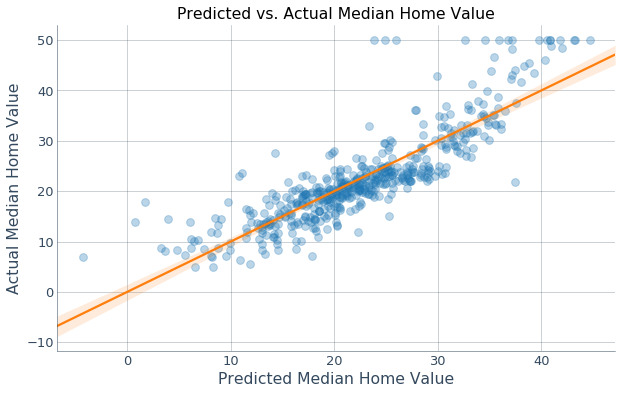

In [41]:
# reg plot: Predicted vs. Actual Median Home Value
sns.regplot(x='PRED_PRICE', y='PRICE', data=bos, fit_reg = True,
            scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
            line_kws={'color': 'C1'})

_ = plt.xlabel('Predicted Median Home Value')
_ = plt.ylabel('Actual Median Home Value')
_ = plt.title('Predicted vs. Actual Median Home Value');

<div class="alert alert-info">
<p><p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p> </p>
</div>

<div class="alert alert-success">
<p>`Scikit-learn` provides a better picture of all of the data points, while `statsmodels` provides many precise measures in a single method call. </p>
</div>

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [42]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11080.276284149873


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [43]:
print(np.sum(lm.predict(X) - np.mean(bos.PRICE)) ** 2)

9.11966625339713e-23


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{ESS}{K}$$
$$MSR = \frac{RSS}{N-K-1}$$

**Remember: ** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

***
<div class="alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>
<p>Let's look at the relationship between `PTRATIO` and housing price.</p>
</div>


<div class="alert alert-info">
<p><b>Exercise:</b> Make a scatterplot of `PTRATIO` and housing price. Tell a story about the relationship between the variables.</p>
</div>


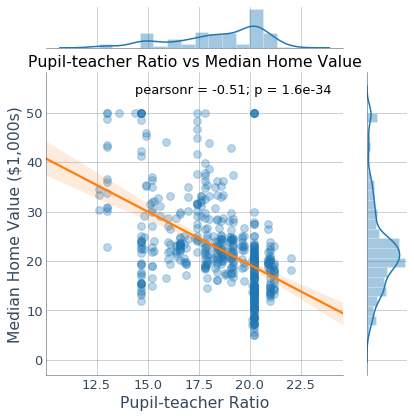

In [44]:
# joint plot: PTRATIO vs PRICE
sns.jointplot('PTRATIO', 'PRICE', data=bos, 
              kind='reg', 
              space=0.6,
              scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
              line_kws={'color': 'C1'})

_ = plt.xlabel('Pupil-teacher Ratio')
_ = plt.ylabel('Median Home Value ($1,000s)')
_ = plt.title('Pupil-teacher Ratio vs Median Home Value');

<div class="alert alert-success">
<p>There is a strong negative correlation between the teacher-pupil ratio and median home value; as the number of students per teacher increases, the median home value decreases, indicating that schools in towns with lower median home values have larger class sizes.</p>
</div>

<div class="alert alert-info">
<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>
<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>
<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>
<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

In [45]:
m_2 = ols('PRICE ~ PTRATIO', bos).fit()
m_2.summary()

print('\n\nR^2: {}'.format(m_2.rsquared))
print('F-statistic: {}'.format(m_2.fvalue))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Wed, 06 Jun 2018   Prob (F-statistic):           1.61e-34
Time:                        14:42:26   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.000      56.393      68.296
PTRATIO       -2.1572      0.163    -13.233      0.000      -2.477      -1.837
==============================================================================
Omnibus:                       92.924   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.444
Skew:                           1.001   Prob(JB):                     2.68e-42
Kurtosis:                       5.252   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



R^2: 0.257847318009223
F-statistic: 175.1055428756955


<div class="alert alert-success">
<p><b>Intercept & Coefficients<\b>: There is a negative correlation between median home value and the pupil-teacher ratio; for every student added to the numerator of the pupil-teacher ratio there is an average decrease of approximately \$2,157 (\$1,000 x -2.1572).  Samples taken in a similar fashion will result in y-intercepts between \$56,393 and \$68,296 95% of the time.</p>

<p><b>$R^2$<\b>: The $R^2$ (the Coefficient of Determination) statistic is one of two measures of the quality of a linear regression fit, the other being $RSE$, or Residual Standard Error.  $R^2$ measures the proportion of variability in Y that can be explained using X.  $R^2$ is always between 0 and 1 and is independent of the scale of Y.  As the $R^2$ value approaches 1, it indicates that a large proportion of the variability in the response has been explained by the regression.  A number closer to 0 indicates that the regression did not explain much of the variability in the response; this might occur because the model is wrong, or the inherent error $\sigma^2$ is high, or both.  The $R^2$ value of 0.258 indicates that just over 25% of the variability in median home value is explained by the variability in the pupil-teacher ratio.</p> 

<p><b>$F$-statistic & $t$-statistic<\b>: The $F$-statistic measures whether there is a relationship between the response and the predictors.  If the $F$-statistic takes on a value close to 1, it indicates that the null hypothesis is true and that there is no relationship between the predictors and the response.  If the $F$-statistic is greater than 1, it indicates that $H_a$ is true, and that there is a relationship between the predictors and the response.  Here, our $F$-statistic of 175 is much greater than 1, and indicates that there is a relationship between the pupil-teacher ratio and the median home value.
$$H_0: \beta_1 = \beta_2 = ... = \beta_p = 0$$
    
$$H_a:\ at\ least\ one\ \beta_j \ne 0$$
</p>  


</div>

<div class="alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [46]:
m_3 = ols('PRICE ~ CRIM + RM + PTRATIO', bos).fit()
m_3.summary()


print('\nF-statistic: {}'.format(m_3.fvalue))
print('\n$R^2$: {}'.format(m_3.rsquared))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     244.2
Date:                Wed, 06 Jun 2018   Prob (F-statistic):           1.09e-97
Time:                        14:42:26   Log-Likelihood:                -1612.6
No. Observations:                 506   AIC:                             3233.
Df Residuals:                     502   BIC:                             3250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3066      4.038     -0.819      0.413     -11.240       4.627
CRIM          -0.2021      0.032     -6.301      0.000      -0.265      -0.139
RM             7.3816      0.402     18.360      0.000       6.592       8.171
PTRATIO       -1.0742      0.133     -8.081      0.000      -1.335      -0.813
==============================================================================
Omnibus:                      233.249   Durbin-Watson:                   0.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2002.374
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                      12.054   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


F-statistic: 244.22387023858764

$R^2$: 0.5934141551136979


<div class="alert alert-success">
<p><b>F-statistic<\b>: The $F$-statistic (244.2) is much greater than 1, indicating that there is a relationship between at least one of the predictors and the response.</p>
<p><b>Coefficient of Determination<\b>: The $R^2$ value of 0.593 indicates that these three factors account for 59% of the variability in the response has been explained by the regression using these three variables.  The $R^2$ value for the PTRATIO alone was just over 0.25, so this represents a 34% improvement in determining the variables that affect the variability of the median home value.</p>

In [47]:
m_3.params

Intercept   -3.306617
CRIM        -0.202110
RM           7.381567
PTRATIO     -1.074187
dtype: float64

<p>The p-values of all three features are 0, indicating that all three are statistically-significant.  The strongest correlation between one of these features and median home value is RM.  It is a postive correlation, and it indicates that for each additional unit of RM, the median home value increases by \$7,381.  PTRATIO has the next highest correlation and it is negative.  For each additional pupil per teacher, the median home value decreases by \$1,074.  CRIM also has a negative correlation, and for each unit of increase in CRIM, the median house value would decrease by \$202.10.  </p>
</div>

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{full} - RSS_{reduced}}{K_{full} - K_{reduced}} \right)}{\left( \frac{RSS_{reduced}}{N - K_{reduced}} \right)}$$

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [48]:
m_4 = ols('PRICE ~ CRIM + RM + PTRATIO + DIS + LSTAT', bos).fit()
m_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     228.5
Date:                Wed, 06 Jun 2018   Prob (F-statistic):          1.25e-126
Time:                        14:42:26   Log-Likelihood:                -1539.3
No. Observations:                 506   AIC:                             3091.
Df Residuals:                     500   BIC:                             3116.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9708      4.079      5.632      0.000      14.957      30.984
CRIM          -0.0903      0.031     -2.953      0.003      -0.150      -0.030
RM             4.3254      0.422     10.250      0.000       3.496       5.154
PTRATIO       -0.9227      0.116     -7.925      0.000      -1.151      -0.694
DIS           -0.6192      0.128     -4.836      0.000      -0.871      -0.368
LSTAT         -0.6258      0.048    -12.956      0.000      -0.721      -0.531
==============================================================================
Omnibus:                      182.217   Durbin-Watson:                   0.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              806.152
Skew:                           1.559   Prob(JB):                    8.84e-176
Kurtosis:                       8.340   Cond. No.                         442.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# create model, adding one new predictors - DIS + LSTAT

rss_reduced = m_3.ssr
rss_full = m_4.ssr
df_reduced = m_3.df_resid
df_full = m_4.df_resid
f = ((rss_reduced - rss_full)/(df_reduced - df_full))/(rss_full/df_full)
print('F-statistic is:', f)

# extract AIC's
print('AIC - reduced: \t{}\nAIC - full: \t{}\nDifference: \t{}'.format(m_3.aic, m_4.aic, m_3.aic - m_4.aic))

F-statistic is: 83.94149566595088
AIC - reduced: 	3233.1002744570037
AIC - full: 	3090.610796526991
Difference: 	142.48947793001253


<div class="alert alert-success">
<p>Adding DIS and LSTAT to the regression equation results in a more accurate model:  
    <ul>
        <li>$R^2$ increases by about 10% (from 0.593 to 0.696), meaning that the features explain more of the variance in the target</li>
        <li>AIC drops 142 points, from 3,233 to 3,090</li>
    </ul>
</div>


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>



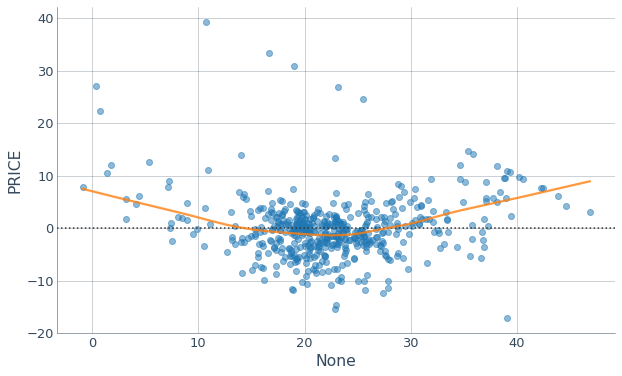

In [50]:
sns.residplot(m_3.fittedvalues, 'PRICE', 
              data=bos, 
              lowess=True, 
              scatter_kws={'color': 'C0', 'alpha': 0.5},
              line_kws={'color': 'C1', 'alpha': 0.8});

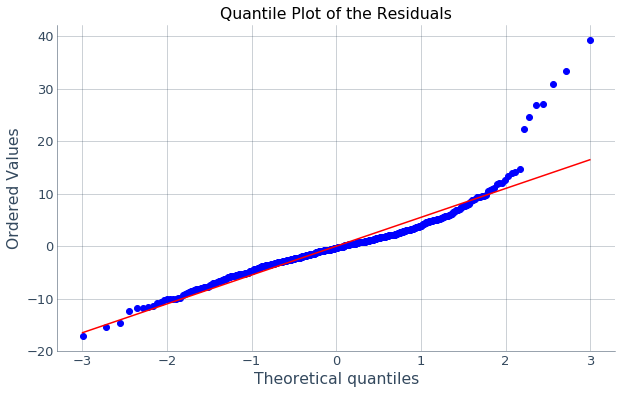

In [51]:
import pylab
# quantile plot of residuals
stats.probplot(m_3.resid, plot=pylab)
_ = plt.title('Quantile Plot of the Residuals');

<div class="alert alert-success">
<p>The QQ plot shows that the residuals are normally-distributed from 0% - ~75%.  The highest seven values are visually outliers.</p>
</div>

In [52]:
# ferret out large residuals
bos['FITTED'] = m_3.fittedvalues
bos['RESIDUALS'] = m_3.resid

large_residuals = bos[bos.RESIDUALS > 20]
len(large_residuals)
large_residuals

7

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,PRED_PRICE,FITTED,RESIDUALS
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,14.291726,0.359783,27.140217
367,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1,10.828258,0.776834,22.323166
368,4.89822,0.0,18.1,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0,23.811350,10.691218,39.308782
369,5.66998,0.0,18.1,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,50.0,32.647872,23.179862,26.820138
370,6.53876,0.0,18.1,1.0,0.631,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96,50.0,34.611634,25.462335,24.537665
371,9.23230,0.0,18.1,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0,24.946041,19.012691,30.987309
372,8.26725,0.0,18.1,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88,50.0,26.002597,16.690622,33.309378


__Outliers__: In linear regression, an outlier is an observation with large residual. In other words, it is an observation whose dependent-variable value is unusual given its values on the predictor variables. An outlier may indicate a sample peculiarity or may indicate a data entry error or other problem.

__Leverage__: An observation with an extreme value on a predictor variable is called a point with high leverage. Leverage is a measure of how far an observation deviates from the mean of that variable. These leverage points can have an effect on the estimate of regression coefficients.

__Influence__: An observation is said to be influential if removing the observation substantially changes the estimate of the coefficients.  Influence can be thought of as the product of leverage and outlierness.

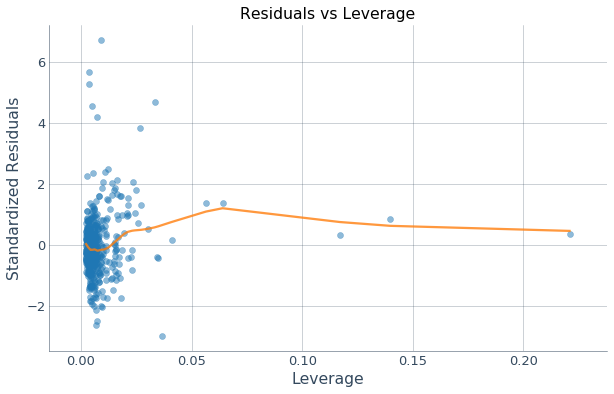

In [53]:
# normalized residuals
model_norm_residuals = m_3.get_influence().resid_studentized_internal

# leverage, from statsmodels internals
model_leverage = m_3.get_influence().hat_matrix_diag

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'C1', 'alpha': 0.8})

_ = plt.title('Residuals vs Leverage')
_ = plt.xlabel('Leverage')
_ = plt.ylabel('Standardized Residuals')



<div class="alert alert-info">
<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

In [54]:
os = m_3.outlier_test(order=True)
lg = os.nlargest(7, 'student_resid')
outliers = list(lg.index)
outliers

# pick top 5 leverage points
model_cooks = m_3.get_influence().cooks_distance[0]

leverage_top_5 = list(np.flip(np.argsort(model_cooks), 0)[:5])

leverage_top_5

to_remove = set(outliers  + leverage_top_5)
to_remove = list(to_remove)

bos2 = bos.drop(bos.index[to_remove])

bos.count()-bos2.count()

[368, 372, 371, 365, 369, 370, 367]

[365, 368, 367, 364, 370]

CRIM          8
ZN            8
INDUS         8
CHAS          8
NOX           8
RM            8
AGE           8
DIS           8
RAD           8
TAX           8
PTRATIO       8
B             8
LSTAT         8
PRICE         8
PRED_PRICE    8
FITTED        8
RESIDUALS     8
dtype: int64

In [55]:
# Remove the outliers and high leverage points from your model and run the regression again. 

m_5 = ols('PRICE ~ CRIM + RM + PTRATIO', bos2).fit()
print('Summary of full model\n{}\n'.format(m_3.summary()))

print('Summary of reduced model\n{}\n'.format(m_5.summary()))

Summary of full model
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     244.2
Date:                Wed, 06 Jun 2018   Prob (F-statistic):           1.09e-97
Time:                        14:42:28   Log-Likelihood:                -1612.6
No. Observations:                 506   AIC:                             3233.
Df Residuals:                     502   BIC:                             3250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3066      4.0

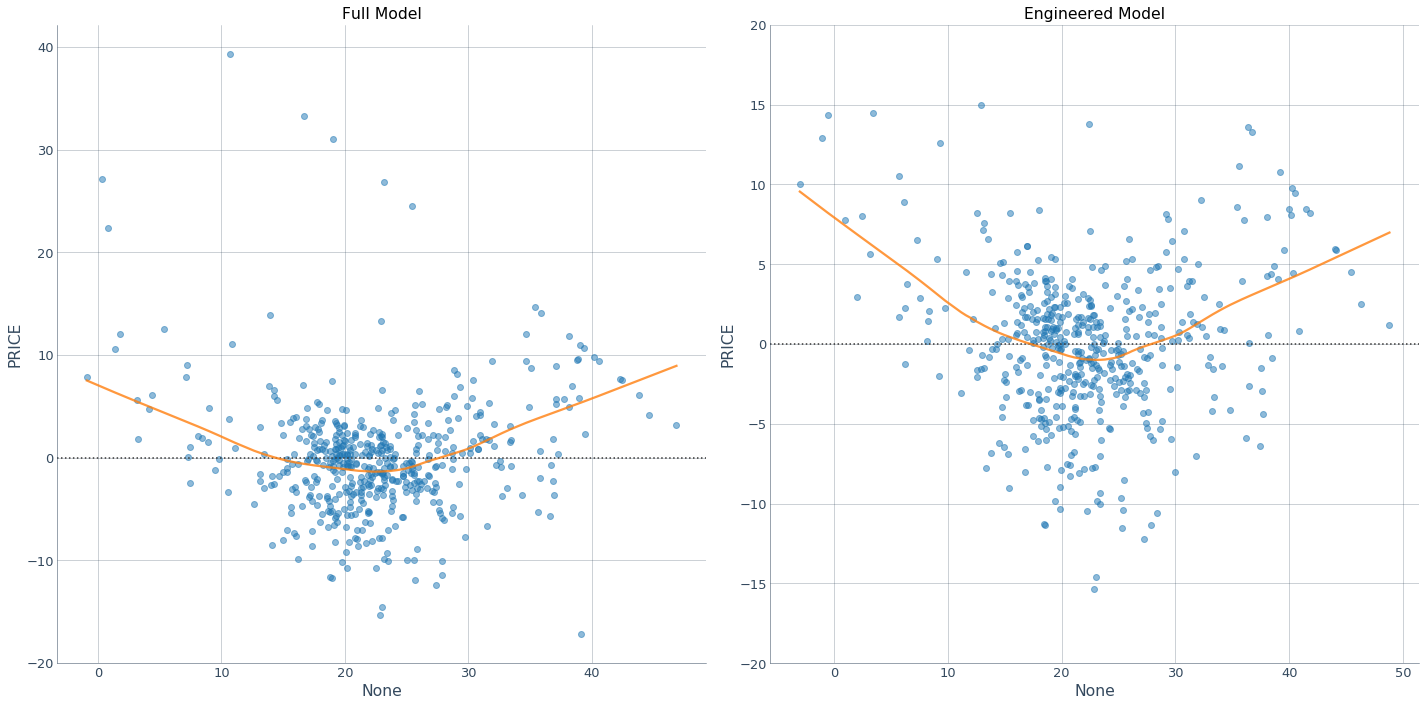

In [56]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.residplot(m_3.fittedvalues, 'PRICE', 
              data=bos, 
              lowess=True, 
              scatter_kws={'color': 'C0', 'alpha': 0.5},
              line_kws={'color': 'C1', 'alpha': 0.8});
_ = plt.title('Full Model')


plt.subplot(1, 2, 2)
sns.residplot(m_5.fittedvalues, 'PRICE', 
              data=bos2, 
              lowess=True, 
              scatter_kws={'color': 'C0', 'alpha': 0.5},
              line_kws={'color': 'C1', 'alpha': 0.8});
plt.ylim(-20, 20)

_ = plt.title('Engineered Model')
_ = plt.tight_layout();

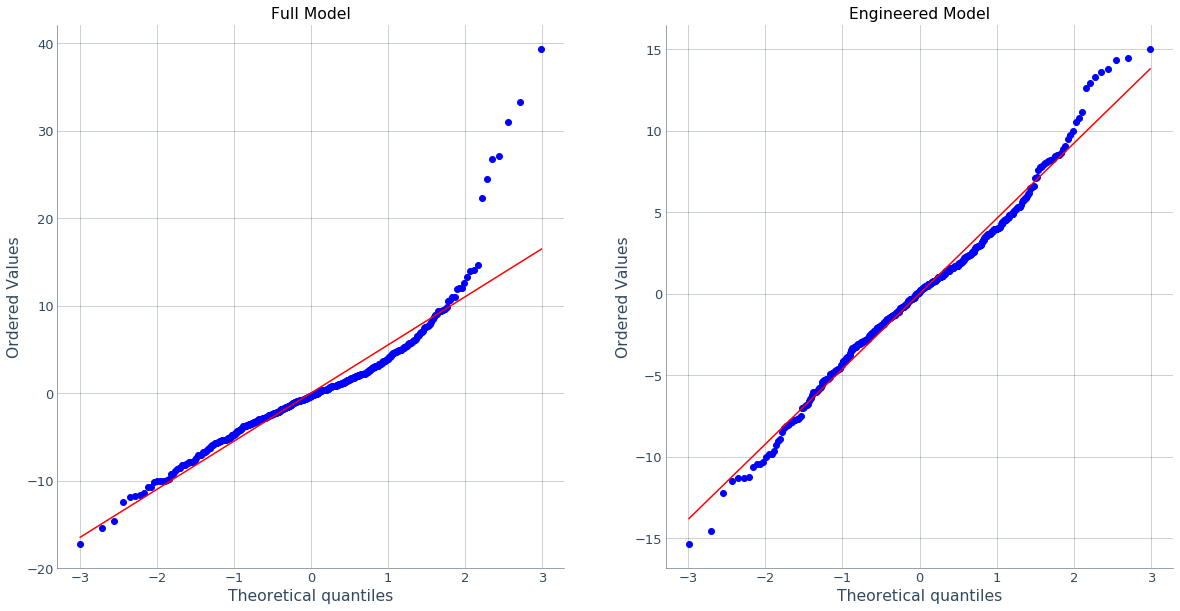

In [57]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
stats.probplot(m_3.resid, plot=pylab)
_ = plt.title('Full Model');

plt.subplot(1, 2, 2)
stats.probplot(m_5.resid, plot=pylab)
_ = plt.title('Engineered Model');

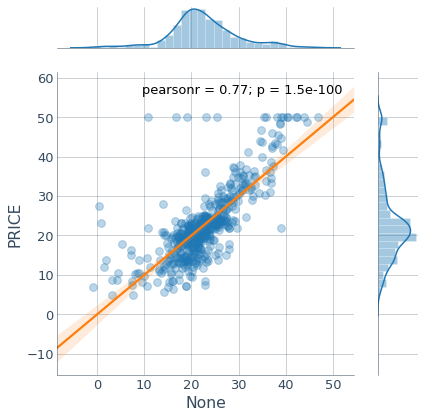

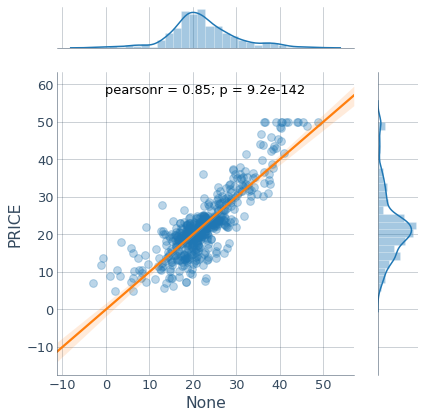

In [58]:
# joint plot: All Features vs PRICE
sns.jointplot(m_3.fittedvalues, 'PRICE', data=bos, 
              kind='reg', 
              space=0.6,
              scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
              line_kws={'color': 'C1'})

# joint plot: Engineered Features vs PRICE
sns.jointplot(m_5.fittedvalues, 'PRICE', data=bos2, 
              kind='reg', 
              space=0.6,
              scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
              line_kws={'color': 'C1'});


<div class="alert alert-success">
<p>By removing the outliers and highest leverage points, the model has improved considerably:
<ul>
    <li>__Coefficient of Determination__ $R^2$ jumped from 0.593 to 0.727.</li>
    <li>__F-statistic__ The F-statistic nearly doubled from 244.2 to 437.5</li>
    <li>__AIC__.  The AIC dropped from 3233 to 2946.</li>
</ul> </p>
</div>